# Import Libraries

In [3]:
import numpy as np
import pandas as pd
import tweepy
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, LSTM
from tensorflow.keras import activations
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import GlobalMaxPooling1D, Conv1D

# Import the Dataset

In [4]:
# Here we are importing our dataset of 100k tweets that we ran through our tweet cleaning script.  
#  As we can see the script is mostly clean, but further cleaning is required
data = pd.read_csv("cleaned_text.csv", encoding='latin1', header = 0)
data

,Unnamed: 0,tweet,punctuation_count,sentiment
0,0,sleep good remedi fall asleep need one,6,0
1,1,work fun,2,0
2,2,summer person love dull cold weather centralco...,3,1
3,3,want smoke cig lighter,2,0
4,4,pass lot twit arriv trend topic bob,8,0
...,...,...,...,...
105236,105236,i i i i i miss trip hehe turn bird amp turtl l...,15,1
105237,105237,hump say,2,0
105238,105238,seriou chemistri revis feel rather ill atm,1,0
105239,105239,weekend go sound like time iphon poker girl let,5,0


# Preparing the Dataset

In [5]:
#Droping the column that was our prior index
data.drop(data.columns[[0]], axis=1, inplace=True)


In [6]:
data.head()

,tweet,punctuation_count,sentiment
0,sleep good remedi fall asleep need one,6,0
1,work fun,2,0
2,summer person love dull cold weather centralco...,3,1
3,want smoke cig lighter,2,0
4,pass lot twit arriv trend topic bob,8,0


In [9]:
# dataset is already balanced
data.sentiment.value_counts() 

0    52657
1    52584
Name: sentiment, dtype: int64

[Text(0, 0, 'Negative'), Text(1, 0, 'Positive')]

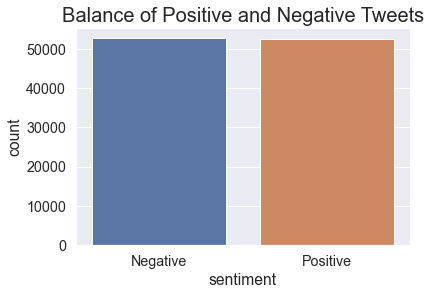

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set(font_scale=1.3)
plot = sns.countplot(x = 'sentiment', data = data)
plot.set_title("Balance of Positive and Negative Tweets", fontsize=20)
plot.set_xticklabels(['Negative','Positive'])

In [11]:
# After our cleaning some of our records have no text information remaining
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105241 entries, 0 to 105240
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   tweet              104742 non-null  object
 1   punctuation_count  105241 non-null  int64 
 2   sentiment          105241 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 2.4+ MB


In [13]:
# We decided to drop these values
data.dropna(subset = ["tweet"], inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104742 entries, 0 to 105240
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   tweet              104742 non-null  object
 1   punctuation_count  104742 non-null  int64 
 2   sentiment          104742 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.2+ MB


# Tokenize

In [15]:
#Splitting our dataset into our label and features
Y = data[['sentiment']]
X = data.drop(['sentiment'], axis=1)
X.head()

,tweet,punctuation_count
0,sleep good remedi fall asleep need one,6
1,work fun,2
2,summer person love dull cold weather centralco...,3
3,want smoke cig lighter,2
4,pass lot twit arriv trend topic bob,8


In [16]:
# Here we are holding our text and punctuation counts in their own objects for safekeeping
tweet = X[['tweet']]
punctuation_counts = X[['punctuation_count']]

In [28]:
# We are using tfidf vectorizer with 8k max features in our model.  In our tfidf function we are using single words and trigrams of our text
# Once tfidf has compiled, we are reappending our punctuation counts to the dataframe

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1,3), stop_words="english", max_features=8000)

tfidf_vect = vectorizer.fit_transform(X['tweet'])
tfidf_feature_names = vectorizer.get_feature_names_out()

tfidf_df = pd.DataFrame (tfidf_vect.todense())
tfidf_df.columns = tfidf_feature_names
tfidf_df['punctuation_count'] = punctuation_counts

In [29]:
#  Here we are using min-max scaler on our punctuation counts to standardize the values

from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing, model_selection

min_max_scaler = preprocessing.MinMaxScaler()
tfidf_df['punctuation_count'] = min_max_scaler.fit_transform(punctuation_counts)

In [30]:
# our final dataset prior to training, the result is a very sparse matrrix of 8001 features
tfidf_df.head()

,ab,abandon,abbi,abc,abil,abit,abl,abl make,abl sleep,absent,...,ze,zealand,zen,zero,zip,zombi,zone,zoo,zoom,punctuation_count
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.057692
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.019231
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028846
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.019231
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076923


# Split Data

In [31]:
#test/train spllitting our data

from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(tfidf_df,
                                                Y,
                                                test_size=0.2,
                                                random_state=10)

In [32]:
Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((83793, 8001), (20949, 8001), (83793, 1), (20949, 1))

In [33]:
# size/shape of dataframe
n_samples = Xtrain.shape[0]
n_featuers = Xtrain.shape[1]

# Our Best Performing Model

In [34]:
# Make the NN -----------------------------------------------------------------
# Importing the Keras libraries and packages

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint

model = keras.Sequential(
    [
        layers.Dense(3000, activation='relu', name='layer1'),
        layers.Dropout(0.5),
        layers.Dense(200, activation='sigmoid', name='layer2'),
        layers.Dense(40, activation='sigmoid', name='layer3'),
        layers.Dense(1, activation='sigmoid', name='output1'),
    ]
)

In [35]:
# Compiling the ANN
model.compile(loss = 'binary_crossentropy' , optimizer = 'adam' , metrics = ['accuracy'] )

In [36]:
# Here we save only our best validation accuracy as a callback.  The best accuracy is then saved as twitter_model
model_save_filename = "twitter_model.h5"
earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
mdlcheckpoint_cb = keras.callbacks.ModelCheckpoint(model_save_filename, monitor="val_accuracy", save_best_only=True)


history = model.fit(
                    Xtrain, 
                    ytrain, 
                    batch_size=10000,
                    epochs=100, 
                    callbacks=[earlystopping_cb, mdlcheckpoint_cb],
                    validation_data = (Xtest, ytest)
                    )

Epoch 1/100
9/9 [==============================] - 13s 812ms/step - loss: 0.6999 - accuracy: 0.5022 - val_loss: 0.6900 - val_accuracy: 0.5054
Epoch 2/100
9/9 [==============================] - 3s 317ms/step - loss: 0.6866 - accuracy: 0.5310 - val_loss: 0.6732 - val_accuracy: 0.6649
Epoch 3/100
9/9 [==============================] - 3s 321ms/step - loss: 0.6510 - accuracy: 0.6730 - val_loss: 0.6102 - val_accuracy: 0.7389
Epoch 4/100
9/9 [==============================] - 3s 319ms/step - loss: 0.5658 - accuracy: 0.7541 - val_loss: 0.5281 - val_accuracy: 0.7447
Epoch 5/100
9/9 [==============================] - 3s 319ms/step - loss: 0.4954 - accuracy: 0.7672 - val_loss: 0.5073 - val_accuracy: 0.7532
Epoch 6/100
9/9 [==============================] - 3s 318ms/step - loss: 0.4689 - accuracy: 0.7815 - val_loss: 0.5079 - val_accuracy: 0.7560
Epoch 7/100
9/9 [==============================] - 3s 316ms/step - loss: 0.4507 - accuracy: 0.7941 - val_loss: 0.5082 - val_accuracy: 0.7560
Epoch 8/100


In [37]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 3000)              24006000  
_________________________________________________________________
dropout_1 (Dropout)          (None, 3000)              0         
_________________________________________________________________
layer2 (Dense)               (None, 200)               600200    
_________________________________________________________________
layer3 (Dense)               (None, 40)                8040      
_________________________________________________________________
output1 (Dense)              (None, 1)                 41        
Total params: 24,614,281
Trainable params: 24,614,281
Non-trainable params: 0
_________________________________________________________________


In [61]:
# Predicting the Test set results
y_pred = model.predict(Xtest)

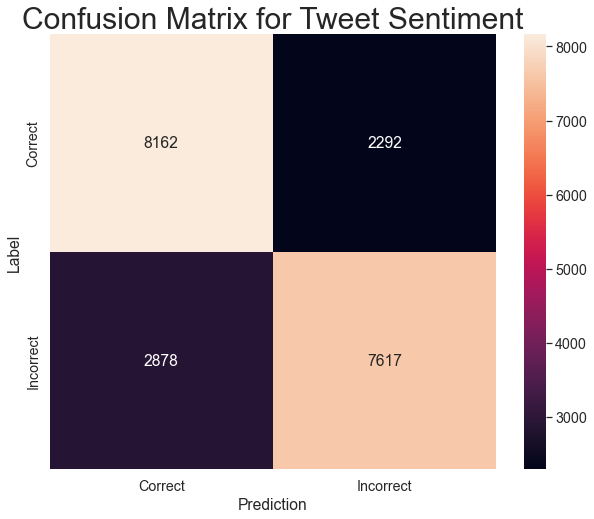

In [67]:
# Making the Confusion Matrix

from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import itertools
import matplotlib.pyplot as plt

pred = y_pred.round()
labels = ytest['sentiment']
title = np.array(['Correct', 'Incorrect'])

confusion_mtx = tf.math.confusion_matrix(labels, pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=title,
            yticklabels=title,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.title("Confusion Matrix for Tweet Sentiment", fontsize=30)
plt.show()

In [42]:
# list all the data in history
print(history.history.keys())


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


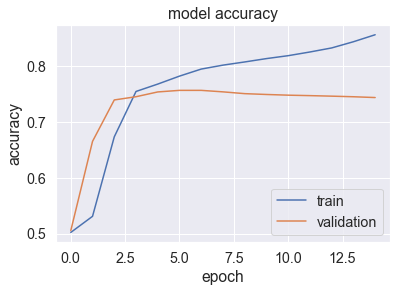

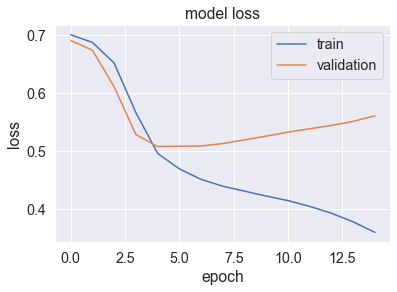

In [68]:
# Plot the accuracy for both train and validation set
plt.subplots() # open a new plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

# Plot the loss for both train and validation set
plt.subplots() # open a new plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

# Traditional ML Models

In [23]:
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

In [42]:
#Random Forest Classifier
RF = RandomForestClassifier(max_depth=10)
RF.fit(Xtrain, ytrain)
y_pred = RF.predict(Xtest)
cm3 = confusion_matrix(y_pred, ytest)
total3=sum(sum(cm3))
Accuracy = (cm3[0,0]+cm3[1,1])/total3
Specificity = cm3[0,0]/(cm3[0,0]+cm3[0,1])
print("Accuracy of  RFC :", Accuracy, "--Specificity of  RFC :", Specificity )

C:\Users\Mike\AppData\Local\Temp/ipykernel_6980/693845353.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF.fit(Xtrain, ytrain)


Accuracy of  RFC : 0.721609623371044 --Specificity of  RFC : 0.7563220940550133


In [25]:
#  GaussianNB 
model5 = GaussianNB()
model5.fit(Xtrain, ytrain)
y_pred = model5.predict(Xtest)
cm5 = confusion_matrix(y_pred, ytest)
total5=sum(sum(cm5))
Accuracy = (cm5[0,0]+cm5[1,1])/total5
    
Specificity = cm5[0,0]/(cm5[0,0]+cm5[0,1])
Sensitivity = cm5[1,1]/(cm5[1,0]+cm5[1,1])
print("Accuracy of  GaussianNB :", Accuracy, "--Sensitivity of  GaussianNB :", Sensitivity, "--Specificity of  GaussianNB :", Specificity )

C:\Users\Mike\.conda\envs\tf-gpu\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of  GaussianNB : 0.6781707957420402 --Sensitivity of  GaussianNB : 0.6545080279950597 --Specificity of  GaussianNB : 0.7108132666969559


# Connect model to Twitter API


In [13]:
# Handle API keys
import os
from dotenv import load_dotenv

In [17]:
# load API_keys
load_dotenv()

API_KEY = os.getenv('API_KEY')
API_KEY_SECRET = os.getenv('API_KEY_SECRET')
BEARER_TOKEN= os.getenv('BEARER_TOKEN')
ACCESS_TOKEN = os.getenv('ACCESS_TOKEN')
ACCESS_TOKEN_SECRET= os.getenv('ACCESS_TOKEN_SECRET')

In [20]:
# load client
def getClient():
    client = tweepy.Client(bearer_token=BEARER_TOKEN,
                           consumer_key=API_KEY,
                           consumer_secret=API_KEY_SECRET,
                           access_token=ACCESS_TOKEN,
                           access_token_secret=ACCESS_TOKEN_SECRET)
    return client

In [21]:
# Load tweets
def searchTweets(client, query, max_results):

    tweets = client.search_recent_tweets(query=query, max_results=max_results)

    tweet_data =  tweets.data
    results = []

    if not tweet_data is None and len(tweet_data) > 0:
        for tweet in tweet_data:
            obj = {}
            obj['id'] = tweet.id
            obj['text'] = tweet.text
            results.append(obj)

    return results

In [22]:
# clean tweets
def returnTweets(query):
    query = '{} lang:en -is:retweet'.format(query)

    client = getClient()
    tweets = searchTweets(client, query, 10)

    objs = []

    if len(tweets) > 0:
        for tweet in tweets:
            obj = {}
            obj['text'] = tweet['text']
            objs.append(obj)

    return(objs)

# Tweet topic 
query = 'canada'
tweets = returnTweets(query)

# Variable for tweet list
list_tweets = []
for i in tweets:
   
    # now i is a dict, now we see the keys
    # of the dict
    for key in i.values():
       
        # print every key of each dict
        list_tweets.append(key)


# Look at the tweets
print(list_tweets)

['@kirstiealley Canada is such a kind country...one your hardly hear about..and now they are YELLING! I love it and support them 100%!!', "Think people, think.\n\nDisagree with the convoy's message? That's ok.\nInvoke the #EmergencyAct to shut it down? Be careful what you wish for.\nWant a full list of donors from @GoFundMe? Ok, but be prepared to cough that up for every fundraiser in Canada. All of them.", 'LOOK AT ALL THE GOODIES 👀 \n#unboxing #pov #OOTD #Canada \nhttps://t.co/KQikBOVIGh', 'On Monday I shared a few thoughts on record high Canadian industrial property prices at the @MSCI_Inc / @realpac Canada Real Estate Investent Forum. I look at the issue here loosely through the lens of the DiPasquale-Wheaton 4-Quadrant model.  https://t.co/lvkXO1gZTj @realcapital https://t.co/vV4aWf0g4e', 'Canada’s Steele Auto expands its U.S. footprint in\xa0Texas https://t.co/gptb3e1M2D', "@kailahdee Do you ship internationally? I'm in Canada", 'Do you support the convoy of truckers protesting v

In [24]:
# Preprocess tweets for prediction

# Load packages
import re
from string import punctuation
from collections import Counter
from nltk.corpus import stopwords

from spellchecker import SpellChecker
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

# Remove stopwords
stopwordlist = stopwords.words('english')
new_stop_words=['i', 'im', 'http', 'ive', 'rt']
for i in new_stop_words:
    stopwordlist.append(i)


In [25]:
# Preprocessing function
def preprocess(textdata):
    processedText = []
    punctuation_counts = []

    # Create Lemmatizer and Stemmer.
    wordstem = PorterStemmer()
    spell = SpellChecker()
    tk = TweetTokenizer()
    
    for tweet in textdata:
        tweet = re.sub(r'@([A-Za-z0-9_]+)', '', tweet)
        punctuation_count = lambda l1,l2: sum([1 for x in l1 if x in l2])
        punctuation_counts.append(punctuation_count(tweet,set(punctuation)))
        tweet = tweet.lower()
        
        # Regex
        tweet = re.sub('[^a-zA-Z]+', ' ', tweet)
        sequencePattern   = r"(.)\1\1+"
        seqReplacePattern = r"\1\1"
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)
        
        tweetwords = ''
        for word in tk.tokenize(tweet):
            # Checking if the word is a stopword.
            if word not in stopwordlist:
                # Spell check the word
                word = spell.correction(word)
                # Lemmatizing the word.
                word = wordstem.stem(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText, punctuation_counts

In [26]:
api_tweets = preprocess(list_tweets)
print(api_tweets)

(['canada kind countri one hardli hear yell love support ', 'think peopl think disagre convoy messag ok invok emergencyact shut care wish want full list donor ok prepar cough everi fundrais canada ', 'look goodi box pov oot canada hate co kqikbovigh ', 'monday share thought record high canadian industri properti price canada real estat invest forum look issu loos len pasqual wheaton quadrant model hate co likeo get hate co ve awf i e ', 'canada steel auto expand u footprint texa hate co get e ', 'ship intern canada ', 'support convoy trucker protest vaccin restrict canada hate co janntkpcbm ', 'cold air canada spill northern tier get colder despit mild start februari obvious anywher near cold wtvmwx hate co xpcncgey ', 'add soccer canada close qualifi world cup ', 'know incompet lead canada '], [9, 13, 9, 15, 7, 2, 6, 11, 3, 2])


In [27]:
# put tweets into a data frame
api_df= pd.DataFrame(api_tweets[0],columns=['tweet'])
api_df['punctuation_count'] = api_tweets[1]

In [28]:
api_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   tweet              10 non-null     object
 1   punctuation_count  10 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 288.0+ bytes


In [29]:
api_tweet = api_df[['tweet']]
api_punctuation_counts = api_df[['punctuation_count']]

In [30]:
# Transform new data into tfidf matrix
api_tfidf_vect = vectorizer.transform(api_df['tweet'])
api_tfidf_feature_names = vectorizer.get_feature_names_out()

api_tfidf_df = pd.DataFrame (api_tfidf_vect.todense())
api_tfidf_df.columns = api_tfidf_feature_names
api_tfidf_df['punctuation_count'] = api_punctuation_counts

In [31]:
# scale punctuation_counts
api_tfidf_df['punctuation_count'] = min_max_scaler.transform(api_punctuation_counts)

In [35]:
# Load the model
model =  load_model('twitter_model.h5')
predictions = model.predict(api_tfidf_df)

In [37]:
list_tweets

['@kirstiealley Canada is such a kind country...one your hardly hear about..and now they are YELLING! I love it and support them 100%!!',
 "Think people, think.\n\nDisagree with the convoy's message? That's ok.\nInvoke the #EmergencyAct to shut it down? Be careful what you wish for.\nWant a full list of donors from @GoFundMe? Ok, but be prepared to cough that up for every fundraiser in Canada. All of them.",
 'LOOK AT ALL THE GOODIES 👀 \n#unboxing #pov #OOTD #Canada \nhttps://t.co/KQikBOVIGh',
 'On Monday I shared a few thoughts on record high Canadian industrial property prices at the @MSCI_Inc / @realpac Canada Real Estate Investent Forum. I look at the issue here loosely through the lens of the DiPasquale-Wheaton 4-Quadrant model.  https://t.co/lvkXO1gZTj @realcapital https://t.co/vV4aWf0g4e',
 'Canada’s Steele Auto expands its U.S. footprint in\xa0Texas https://t.co/gptb3e1M2D',
 "@kailahdee Do you ship internationally? I'm in Canada",
 'Do you support the convoy of truckers protes

In [41]:
# Join the predicions and tweets togeather
change_sent_df= pd.DataFrame(predictions,columns=['predictions'])
change_sent_df['tweets'] = list_tweets

In [46]:
# 1 for Postive
# 0 for Negative
change_sent_df=change_sent_df[change_sent_df.predictions < 0.5]
change_sent_df

,predictions,tweets
1,0.176737,"Think people, think.\n\nDisagree with the conv..."
2,0.253721,LOOK AT ALL THE GOODIES 👀 \n#unboxing #pov #OO...
3,0.225488,On Monday I shared a few thoughts on record hi...
4,0.166089,Canada’s Steele Auto expands its U.S. footprin...
6,0.314327,Do you support the convoy of truckers protesti...
7,0.096210,Very cold air in Canada once again spilling in...


# Change the sentiment of Negative tweets

In [42]:
# Import Libraries
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
from nltk.tokenize import TweetTokenizer

[nltk_data] Downloading package wordnet to /Users/juan-
[nltk_data]     lukeclackworthy/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [43]:
# Get Atonyms and repace adjectives
def get_antonyms_for_adjective(word):
    antonyms = []
    for word_sysnet in wn.synsets(word):
        if word_sysnet.pos() in ['a', 's']: # Only consider adjectives
          for lemma in word_sysnet.lemmas():
              # a lemma is info about a word. For instance, adject bad: Synset('bad.a.01')
              any_pos_antonyms = [ antonym.name() for antonym in lemma.antonyms() ]
              for antonym in any_pos_antonyms:
                  antonym_synsets = wn.synsets(antonym)
                  if wn.ADJ not in [ ss.pos() for ss in antonym_synsets ]:
                      continue
                  antonyms.append(antonym)
    return antonyms

def change_sentence_sentiment(sentence):
    tk = TweetTokenizer()
    new_sentence = []

    for word in tk.tokenize(sentence):
        antonyms = get_antonyms_for_adjective(word)
        
        if len(antonyms) == 0:
            new_sentence.append(word)
        else:
            new_sentence.append(antonyms[0])
    
    return ' '.join(new_sentence)

In [44]:
sentence = "dogecoin is an awful asset, really anyone who invests in it is stupid"
print(change_sentence_sentiment(sentence))

dogecoin is an nice asset , really anyone who invests in it is smart


In [73]:
changed_sent_df = change_sent_df[['tweets']]
changed_sent_df

,tweets
1,"Think people, think.\n\nDisagree with the conv..."
2,LOOK AT ALL THE GOODIES 👀 \n#unboxing #pov #OO...
3,On Monday I shared a few thoughts on record hi...
4,Canada’s Steele Auto expands its U.S. footprin...
6,Do you support the convoy of truckers protesti...
7,Very cold air in Canada once again spilling in...


In [74]:
changed_sent_df['Changed Sentence'] = changed_sent_df['tweets'].apply(lambda x: change_sentence_sentiment(x))

In [81]:
changed_sent_df

,tweets,Changed Sentence
1,"Think people, think.\n\nDisagree with the conv...","Think people , think . Disagree with the convo..."
2,LOOK AT ALL THE GOODIES 👀 \n#unboxing #pov #OO...,LOOK AT some THE GOODIES 👀 #unboxing #pov #OOT...
3,On Monday I shared a few thoughts on record hi...,off Monday I unshared a many thoughts off reco...
4,Canada’s Steele Auto expands its U.S. footprin...,Canada ’ s Steele Auto expands its U . S . foo...
6,Do you support the convoy of truckers protesti...,Do you support the convoy of truckers protesti...
7,Very cold air in Canada once again spilling in...,Very hot air in Canada once again spilling int...
